In [ ]:
import os
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm.notebook import tqdm

from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [ ]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(42)

Random seed set as 42


### Данные

In [ ]:
df = pd.read_csv('Electrical_Grid_Stability.csv', sep=';')
df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stability
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,1
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0


In [ ]:
X, y = df.drop('stability', axis=1), df['stability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train.shape, X_val.shape, X_test.shape

((6000, 12), (2000, 12), (2000, 12))

### Обертки для данных

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X.values)
        self.y = torch.from_numpy(y.values).reshape(-1, 1).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return (self.X[index], self.y[index])

In [ ]:
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Модель

In [ ]:
class BestTorchModel(nn.Module):
    def __init__(self, num_labels, input_size, hidden_size, n_linear_layers=3, activation=nn.Sigmoid):
        super(BestTorchModel, self).__init__()

        layers = [nn.Linear(input_size, hidden_size), activation()]

        for i in range(n_linear_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(activation())

        layers.append(nn.Linear(hidden_size, num_labels))
        self.layers = nn.Sequential(*layers) # https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html

    def forward(self, x):
        y_pred = torch.sigmoid(self.layers(x))
        return y_pred

In [ ]:
def train_model(model, num_epochs=100, eval_freq=10):
  train_loss_history, eval_loss_history = [], []
  train_f1_history, eval_f1_history = [], []
  global_step = 0

  model.train()
  for epoch in tqdm(range(num_epochs)):
      for batch_X, target in train_dataloader:
        optimizer.zero_grad()
        log_probs = model(batch_X.to(device))
        loss = loss_function(log_probs, target.to(device))
        loss.backward()
        optimizer.step()

        preds = (log_probs >= 0.5).int().cpu()
        f1 = f1_score(preds, target.cpu().numpy())

        train_loss_history.append((global_step, loss.item()))
        train_f1_history.append((global_step, f1.item()))

        if global_step % eval_freq == 0:
              val_loss, val_f1 = evaluate(model)
              eval_loss_history.append((global_step, val_loss))
              eval_f1_history.append((global_step, val_f1))

              model.train()

        if global_step % 250 == 0:
              clear_output(True)

              plt.figure(figsize=(15, 5))

              plt.subplot(121)
              plt.plot(*zip(*train_loss_history), alpha=0.5, label='train_loss')
              if len(eval_loss_history):
                  plt.plot(*zip(*eval_loss_history), color='red', label='eval_loss')
              plt.legend()

              plt.subplot(122)
              plt.plot(*zip(*train_f1_history), alpha=0.5, label='train_f1')
              if len(eval_f1_history):
                  plt.plot(*zip(*eval_f1_history), color='red', label='eval_f1')
              plt.legend()
              plt.show()
        global_step += 1

  return model

In [ ]:
@torch.no_grad()
def evaluate(model, data_loader=val_dataloader):
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()
    loss_epoch = 0.
    num_epoch = 0.
    preds_list = []
    targets_list = []

    for batch_X, target in data_loader:
      log_probs = model(batch_X.to(device))
      loss = loss_function(log_probs, target.to(device))
      num = log_probs.shape[0]
      loss_epoch += loss.item() * num
      num_epoch += num

      preds_list += (log_probs >= 0.5).int().cpu().tolist()
      targets_list += target.cpu().numpy().tolist()

    f1 = f1_score(preds_list, targets_list)

    return loss_epoch / num_epoch, f1

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Первая попытка обучения

In [ ]:
model = BestTorchModel(1, 12, 12, 3, nn.Sigmoid)
model.to(device)

BestTorchModel(
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=12, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=12, out_features=12, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=12, out_features=12, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=12, out_features=1, bias=True)
  )
)

In [ ]:
loss_function = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

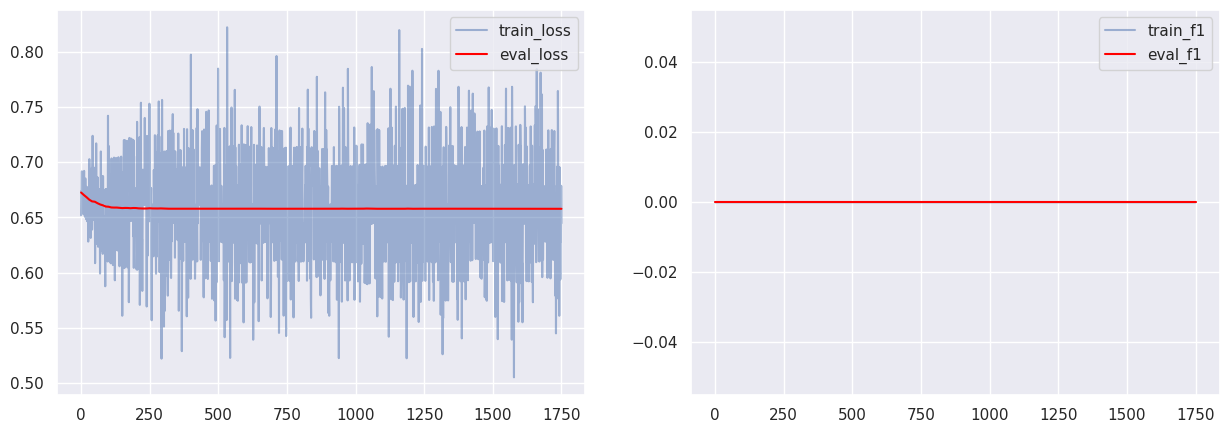

In [ ]:
model = train_model(model, num_epochs=10)

In [ ]:
evaluate(model, data_loader=test_dataloader)

(0.6462398977279663, 0.0)

#### Посмотрим, что происходит внутри...

In [ ]:
from collections import defaultdict

In [ ]:
model = BestTorchModel(1, 12, 12, 3, nn.Sigmoid)
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
def get_forward_hook(history_dict, key):
    def forward_hook(self, input_, output):
        history_dict[key] = input_[0].cpu().detach().numpy().flatten()

    return forward_hook


def get_backward_hook(history_dict, key):
    def backward_hook(grad):  # for tensors
        history_dict[key] = grad.abs().cpu().detach().numpy().flatten()

    return backward_hook


def register_model_hooks(model):
    cur_ind = 0
    history_dict = defaultdict(list)
    for child in model.layers.children():
        if isinstance(child, nn.Linear):
            forward_hook = get_forward_hook(history_dict, key=f"sigmoid_out_{cur_ind}")
            child.register_forward_hook(forward_hook)

            cur_ind += 1
            backward_hook = get_backward_hook(
                history_dict, key=f"gradient_linear_{cur_ind}"
            )
            child.weight.register_hook(backward_hook)
    return history_dict

In [ ]:
hooks_data_history = register_model_hooks(model)

In [ ]:
def plot_hooks_data(hooks_data_history):
    keys = hooks_data_history.keys()
    n_layers = len(keys) // 2

    activation_names = [f"sigmoid_out_{i}" for i in range(1, n_layers)]
    activations_on_layers = [
        hooks_data_history[activation] for activation in activation_names
    ]

    gradient_names = [f"gradient_linear_{i + 1}" for i in range(n_layers)]
    gradients_on_layers = [hooks_data_history[gradient] for gradient in gradient_names]

    for plot_name, values, labels in zip(
        ["activations", "gradients"],
        [activations_on_layers, gradients_on_layers],
        [activation_names, gradient_names],
    ):
        fig, ax = plt.subplots(1, len(labels), figsize=(14, 4), sharey="row")
        for label_idx, label in enumerate(labels):
            ax[label_idx].boxplot(values[label_idx], labels=[label])
        plt.show()

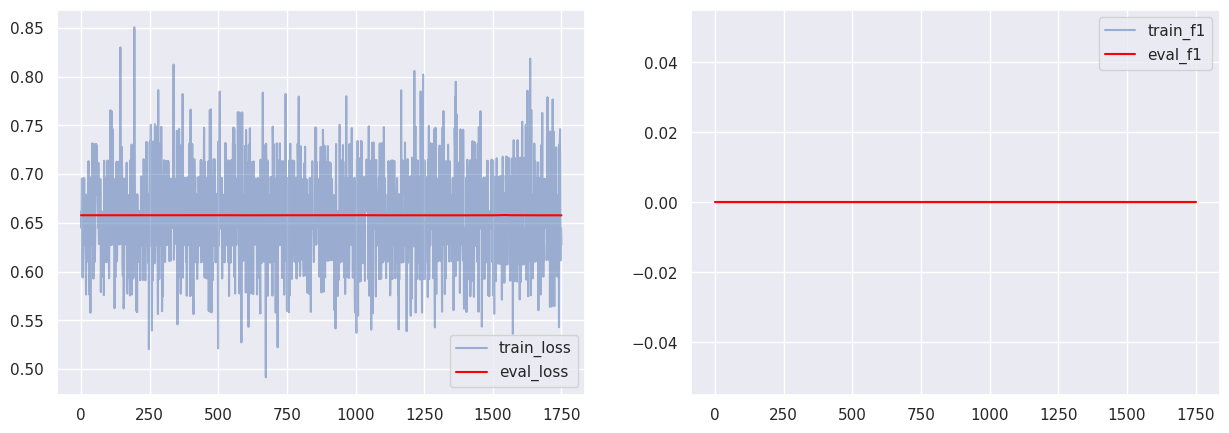

In [ ]:
model = train_model(model, num_epochs=10)

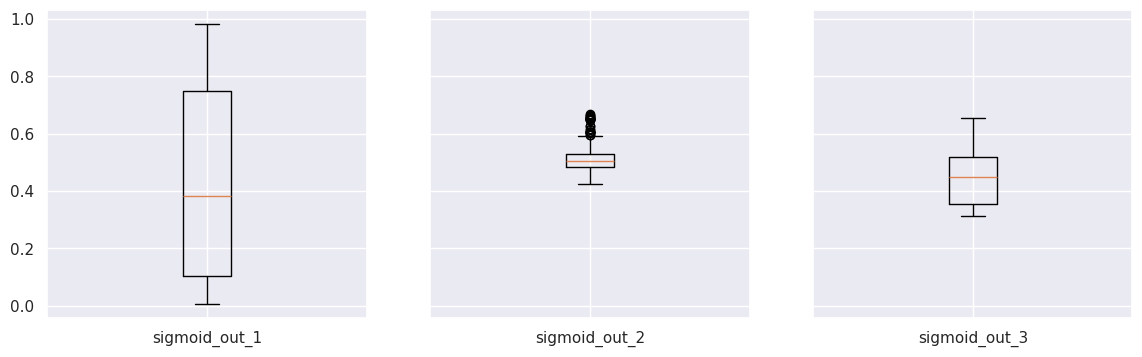

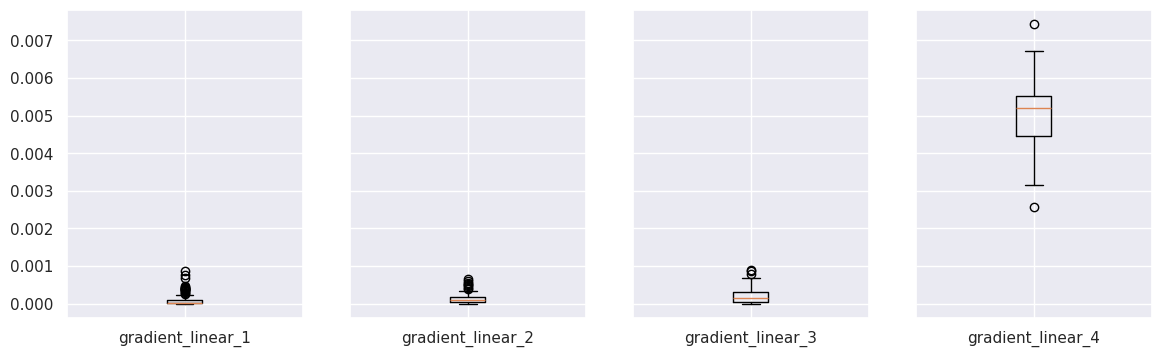

In [ ]:
plot_hooks_data(hooks_data_history)

### Проблема - Затухание градиентов

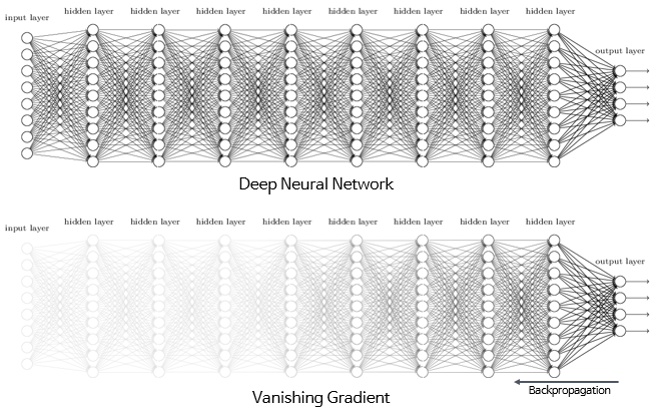

Откуда оно берется?

Посмотрим на обычную сигмоиду:

$$\sigma(z) = \dfrac 1 {1 + e^{-z}}$$

Ее производная равна:

$$\dfrac {\partial \sigma(z)} {\partial z} = \sigma(z) (1 - \sigma(z))$$

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/activation_function_sigmoid.png" width="1000"></center>

Какое максимальное значение у такой функции?

Сигмоида находится в пределах от $0$ до $1$. **Максимальное значение производной** сигмоиды  $=\dfrac 1 4$.

Теперь возьмем простую нейронную сеть:


<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/simple_nn_with_sigmoid.png" width="750">

Посчитаем у нее градиент:

$$\dfrac {\partial L} {\partial z_4} = \dfrac {\partial L} {\partial y} \dfrac {\partial y} {\partial z_4} = \dfrac {\partial L} {\partial y} \dfrac {\partial \sigma(w_5z)} {\partial z} w_5 \le \dfrac 1 4 \dfrac {\partial L} {\partial y}  w_5 $$

Аналогично можно посчитать градиент для $z_3$:

$$\dfrac {\partial L} {\partial z_3} = \dfrac {\partial L} {\partial z_4} \dfrac {\partial z_4} {\partial z_3} \le \dfrac {\partial L} {\partial y} \dfrac {\partial \sigma(w_4z)} {\partial z} w_5 \le \left({\dfrac 1 4}\right)^2 \dfrac {\partial L} {\partial y}  w_5 w_4$$

И так далее:

$$\dfrac {\partial L} {\partial x}  \le \left({\dfrac 1 4}\right)^5 \dfrac {\partial L} {\partial y}  w_5 w_4 w_3 w_2 w_1$$

#### Решаем проблему

Заменим внутреннюю функцию активации... но на что?

####  Функции активации

#### Требования к функциям активации

1. **Нелинейность:** Функции активации добавляют нелинейность, необходимую для аппроксимации сложных функций, чего нельзя достичь простой линейной моделью. Без нелинейностей нейронные сети действуют как линейные модели.

2. **Дифференцируемость:** Функции активации должны быть дифференцируемыми, чтобы применять градиентные методы оптимизации.

####  Некоторые функции активации

Рассмотрим наиболее популярные функции активации и обсудим их преимущества и недостатки.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L05/popular_activation_functions.png" width="700"></center>

<center><em>Source: <a href="https://arxiv.org/pdf/1911.05187.pdf">AI in Pursuit of Happiness, Finding Only Sadness: Multi-Modal Facial Emotion Recognition Challenge</a></em></center>

#####  Сигмоида

Логистическая (сигмоидальная) функция — используется в задачах бинарной классификации, в основном после выхода последнего нейрона. Позволяет определить вероятность принадлежности к одному из двух классов (0 или 1).

$$\large \sigma(x)=\frac{1}{1+e^{-x}}$$

Свойства логистической функции активации:
1. **Диапазон значений:** От $0$ до $1$, что позволяет моделировать вероятности. Полезна в задачах бинарной и multi-label классификации
2. **Гладкость:** Дифференцируема, что упрощает обучение
3. **Насыщение:** Насыщается при больших/малых значениях, приводя к затуханию градиента

Применяется в основном для задач бинарной классификации. Реже используется в скрытых слоях из-за проблемы затухания градиента.

[torch.nn.Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html)

#####  Гиперболический тангенс

Гиперболический тангенс схож с логистической функцией. Он определяется следующей формулой:

$$\large \tanh(x)=\frac{e^x - e^{-x}}{e^x+e^{-x}}$$

Также гиперболический тангенс может быть выражен через логистическую функцию:

$$\large \tanh(x) = 2\cdot\sigma(2x)-1$$

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L05/out/activation_function_tanh.png" width="1000"></center>

Гиперболический тангенс обладает следующими свойствами:
1. **Диапазон значений:** От $-1$ до $1$, симметричен относительно нуля.
2. **Гладкость:** Дифференцируем, облегчает обучение.
3. **Более высокая чувствительность:** Более чувствителен к изменениям входа, чем сигмоида.
4. **Центрирование вокруг нуля:** Ускоряет сходимость обучения - нет систематического смещения в сторону горизонтальных асимптот
5. **Насыщение:** Насыщается на краях, что приводит к затуханию градиента.

Используется для внутренних представлений, симметричных вокруг нуля, иногда применяется в скрытых слоях.

[torch.nn.Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html)


#####  ReLU

Часто на практике применяется функция активации ReLU. Значение данной функции равно нулю для всех отрицательных входных значений и равно входному значению, если оно неотрицательно.

$$\large \text{ReLU}(x)=\max(0,x)$$

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L05/out/activation_function_relu.png" width="1000"></center>

Производная ReLU:

$$\frac{d}{dx}\text{ReLU}(x) =
\begin{cases}
\displaystyle \frac{d}{dx}0, &\text{$x<0$} \\
\displaystyle \frac{d}{dx}x, &\text{$x\geq0$}
\end{cases}=
\begin{cases}
0, &\text{$x<0$} \\
1, &\text{$x\geq0$}
\end{cases}
$$

Функция ReLU имеет следующие свойства:
1. **Диапазон значений:** От 0 до $\infty$, обнуляет отрицательные значения.
2. **Отсутствие насыщения:** Не насыщается при положительных значениях, способствуя эффективному обучению.
3. **Простота:** Легка в вычислении и реализации.
4. **Проблема "умерших" нейронов:** Нулевой градиент для отрицательных входов останавливает обновление весов.

ReLU широко используется в скрытых слоях глубоких нейронных сетей благодаря своей эффективности.

[torch.nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)

##### Leaky ReLU

Leaky ReLU — модификация ReLU, которая решает проблему "умирания" нейронов, вводя небольшую линейную зависимость в отрицательной области, которая регулируется параметром $\alpha$.

$$\large \text{LeakyReLU}(x, \alpha)=\max(\alpha x,x), \ \ \ \alpha<1$$

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L05/out/activation_function_leaky_relu.png" width="1000"></center>

Производная Leaky ReLU:

$$\large \frac{d}{dx}\text{LeakyReLU}(x)=\frac{d}{dx}\max(\alpha x,x)=\begin{cases}
\displaystyle \frac{d}{dx}\alpha x, &\text{$x<0$} \\
\displaystyle \frac{d}{dx}x, &\text{$x\geq0$}
\end{cases}=
\begin{cases}
\alpha, &\text{$x<0$} \\
1, &\text{$x\geq0$}
\end{cases}$$

Свойства LeakyReLU:

1. **Диапазон значений:** От $-\infty$ до $+\infty$.
2. **Отсутствие насыщения:** Не насыщается, что предотвращает затухание градиента.
3. **Простота:** Легко вычисляется и дифференцируется.
4. **Преодоление проблемы "умерших" нейронов:** Ненулевой наклон для отрицательных значений устраняет эту проблему.
5. **Дополнительный гиперпараметр:** Требуется настройка наклона для отрицательной части.

Leaky ReLU используется в скрытых слоях для предотвращения проблемы "умерших" нейронов, особенно в глубоких нейронных сетях.

[torch.nn.LeakyReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html)


#### Посмотрим, что получилось

In [ ]:
model = BestTorchModel(1, 12, 12, 3, nn.ReLU)
model.to(device)

BestTorchModel(
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=12, bias=True)
    (3): ReLU()
    (4): Linear(in_features=12, out_features=12, bias=True)
    (5): ReLU()
    (6): Linear(in_features=12, out_features=1, bias=True)
  )
)

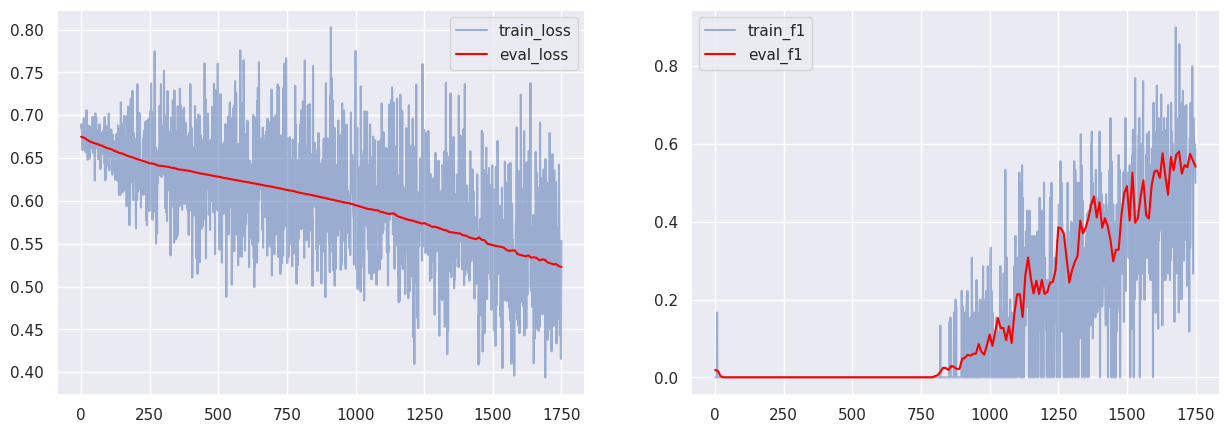

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
hooks_data_history = register_model_hooks(model)
model = train_model(model, num_epochs=10)

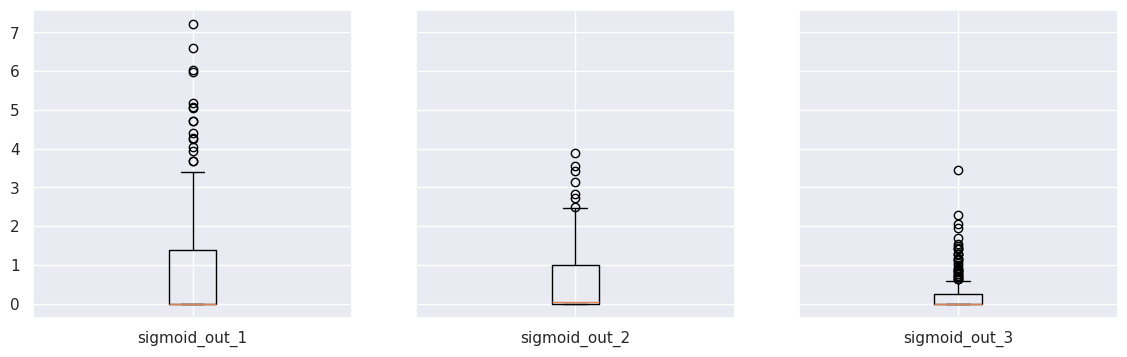

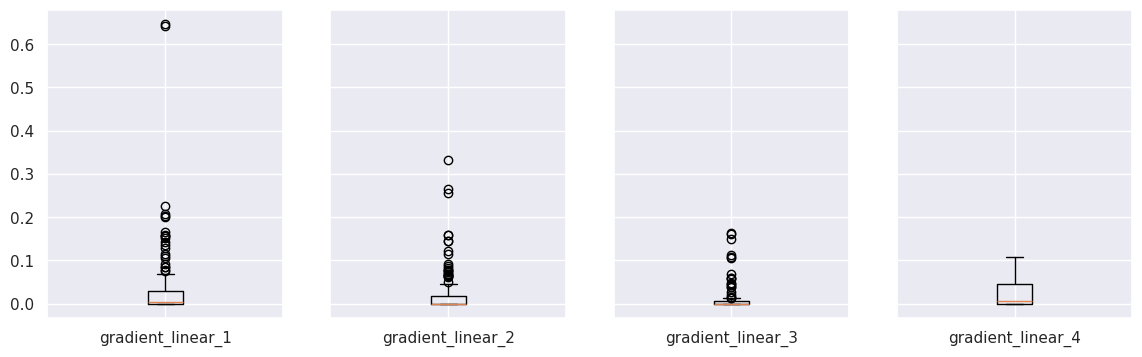

In [ ]:
plot_hooks_data(hooks_data_history)

[Comparison of non-linear activation functions for deep neural networks on
MNIST classification task](https://arxiv.org/pdf/1804.02763)

### Еще одна модель...

`Linear` из PyTorch какой-то сложный... Используем-ка свою реализацию

In [ ]:
class CustomLinear(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros((dim_out, dim_in)))
        self.bias = nn.Parameter(torch.zeros(dim_out))

    def forward(self, input):
        return F.linear(input, self.weight, self.bias)

In [ ]:
class BestTorchModel_zeros(nn.Module):
    def __init__(self, num_labels, input_size, hidden_size, n_linear_layers=3, activation=nn.ReLU):
        super(BestTorchModel_zeros, self).__init__()

        layers = [CustomLinear(input_size, hidden_size), activation()]

        for i in range(n_linear_layers - 1):
            layers.append(CustomLinear(hidden_size, hidden_size))
            layers.append(activation())

        layers.append(CustomLinear(hidden_size, num_labels))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        y_pred = torch.sigmoid(self.layers(x))
        return y_pred

In [ ]:
model = BestTorchModel_zeros(1, 12, 12, 3, nn.ReLU)
model.to(device)

BestTorchModel_zeros(
  (layers): Sequential(
    (0): CustomLinear()
    (1): ReLU()
    (2): CustomLinear()
    (3): ReLU()
    (4): CustomLinear()
    (5): ReLU()
    (6): CustomLinear()
  )
)

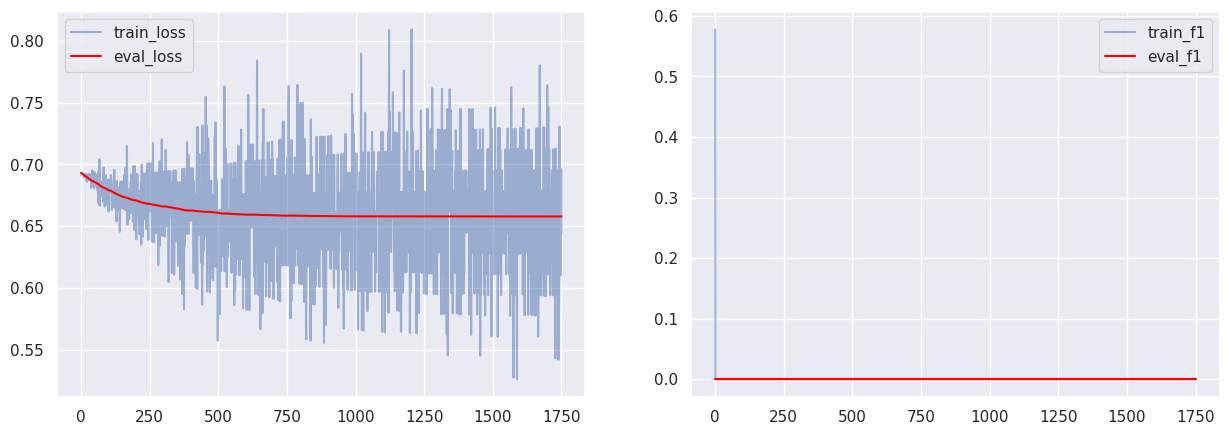

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
model = train_model(model, num_epochs=10)

In [ ]:
class CustomLinear(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.weight = nn.Parameter(torch.ones((dim_out, dim_in)))
        self.bias = nn.Parameter(torch.ones(dim_out))

    def forward(self, input):
        return F.linear(input, self.weight, self.bias)


class BestTorchModel_ones(nn.Module):
    def __init__(self, num_labels, input_size, hidden_size, n_linear_layers=3, activation=nn.ReLU):
        super(BestTorchModel_ones, self).__init__()

        layers = [CustomLinear(input_size, hidden_size), activation()]

        for i in range(n_linear_layers - 1):
            layers.append(CustomLinear(hidden_size, hidden_size))
            layers.append(activation())

        layers.append(CustomLinear(hidden_size, num_labels))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        y_pred = torch.sigmoid(self.layers(x))
        return y_pred

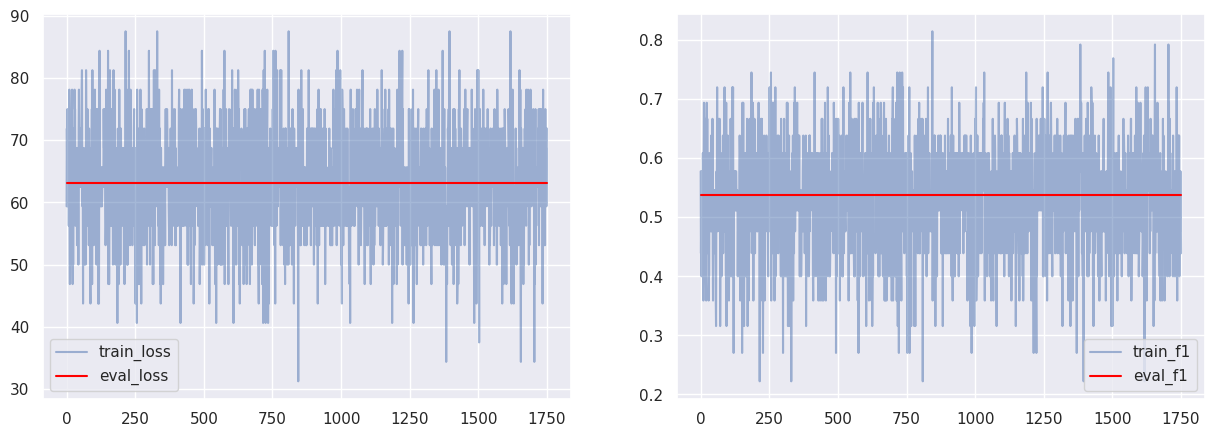

In [ ]:
model = BestTorchModel_ones(1, 12, 12, 3, nn.ReLU)
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01)
model = train_model(model, num_epochs=10)

### Проблема - Неудачная инициализация весов

[Вспомним, что есть в настоящем Linear слое](https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear)

[Почему инициализировать веса нейронной сети одинаковыми значениями (например, нулями) – это плохая идея](https://habr.com/ru/articles/592711/)

 **TLDR**: нейросеть может не обучаться совсем или обучаться плохо

#### Решаем проблему

#### Нормальное распределение

**Идея 2:** инициализировать веса нормальным (Гауссовским) шумом с матожиданием $0$ и маленькой дисперсией.

Маленькая дисперсия нужна, чтобы не получить огромные градиенты за большие изначальные ошибки в предсказании.

In [ ]:
class BestTorchModel_normal(nn.Module):
    def __init__(self, num_labels, input_size, hidden_size, n_linear_layers=3, activation=nn.ReLU):
        super(BestTorchModel_normal, self).__init__()

        layers = [nn.Linear(input_size, hidden_size), activation()]

        for i in range(n_linear_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(activation())

        layers.append(nn.Linear(hidden_size, num_labels))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        y_pred = torch.sigmoid(self.layers(x))
        return y_pred

    def init_weights(module):
      if isinstance(module, (nn.Linear)):
          torch.nn.init.normal_(module.weight, mean=0.0, std=1.0)
          if module.bias is not None:
              torch.nn.init.zeros_(module.bias)

[torch.nn.init](https://pytorch.org/docs/stable/nn.init.html)

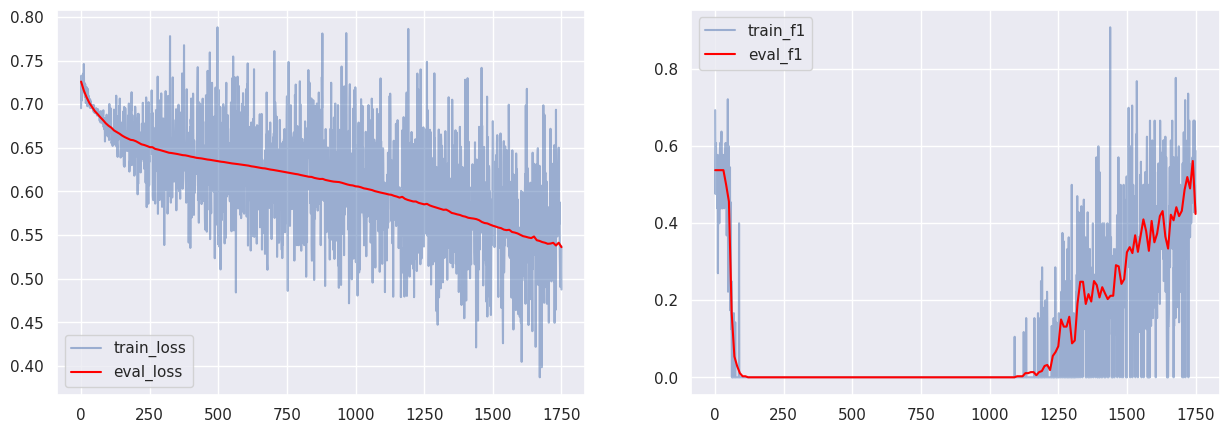

In [ ]:
model = BestTorchModel_normal(1, 12, 12, 3, nn.ReLU)
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01)
model = train_model(model, num_epochs=10)

In [ ]:
evaluate(model, data_loader=test_dataloader)

(0.5197131886482239, 0.5313653136531366)

**Проблема**: инициализация нормальным шумом не гарантирует отсутствие взрыва или затухания градиента.

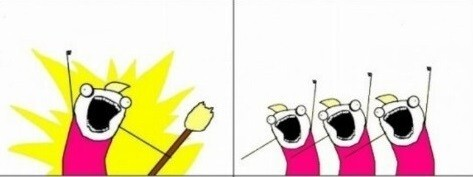

- Нарушение симметричности  чтобы нейроны были разные
- Недопустить «насыщенность» нейрона
- Входы на все слои должны иметь одинаковую дисперсию (для избегания «насыщения» нейронов) - это показатель, что сигнал проходит и не затухает / увеличивается

**Идея 3:** формализуем условия, при которых взрыв и затухание градиентов не будут происходить.

1. Нам бы хотелось, чтобы **дисперсии признаков**, получаемых на каждом слое, были одинаковы (т.е мы хотим задать начальные веса таким образом, чтобы входные признаки каждого линейного слоя были **одинаково нормализованы**).

Это важно, т.к. значения признаков используются при расчете градиента. Например, для линейного слоя:

$$y = wx+b$$
$$\dfrac{\partial y} {\partial w} = x$$

Запишем это условие:

$$Dz^i = Dz^j \tag{1}$$

2. Нам бы хотелось, чтобы **дисперсии градиентов** для разных слоев были одинаковы:

$$D\dfrac {\partial L} {\partial z^i} = D\dfrac {\partial L} {\partial z^j} \tag{2}$$


При выполнении этих условий градиент **не затухает** и **не взрывается**.

Инициализации Ксавье и Ге выводятся из этих условий.

#### Инициализация Ксавье (Xavier Glorot)

Инициализация Ксавье была предложена в статье [Understanding the difficulty of training deep feedforward neural networks (Xavier et al., 2010)](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf). Она используется для симметричных функций активации (**Sigmoid**, **Tanh**).

При инициализации весов равномерным распределением условия (1) и (2) преобразуются в:

 $$W_i \sim U[-\sqrt{\dfrac {6} {n_i + n_{i + 1}}}, \sqrt{\dfrac {6} {n_i + n_{i + 1}}}],$$

где $n_i$ — размерность выхода $i$-го слоя.

При инициализации весов нормальным распределением условия (1) и (2) преобразуются в:

$$W_i \sim N (0,  \text{std}=\sqrt{\dfrac{2}{n_i + n_{i + 1}}})$$

Можно использовать любое распределение.

#### Инициализация Ге (Kaiming He)

Инициализация Ге была предложена в статье
[Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification (He et al., 2015)](https://arxiv.org/pdf/1502.01852v1.pdf). Она используется для функции активации **ReLU** и ее модификаций (**PReLU**, **Leaky ReLU** и т.д.).

При инициализации весов нормальным распределением условия (1) и (2) преобразуются в:

$$W_i \sim N(0, \text{std}=\sqrt{\frac 2 {n_i}})$$

Для равномерного распределения:
$$W_i \sim U(-\sqrt{\frac 3 {n_i}}, \sqrt{\frac 3 {n_i}})$$



In [ ]:
import math

In [ ]:
class BestTorchModel_kaiming(nn.Module):
    def __init__(self, num_labels, input_size, hidden_size, n_linear_layers=3, activation=nn.ReLU):
        super(BestTorchModel_kaiming, self).__init__()

        layers = [nn.Linear(input_size, hidden_size), activation()]

        for i in range(n_linear_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(activation())

        layers.append(nn.Linear(hidden_size, num_labels))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        y_pred = torch.sigmoid(self.layers(x))
        return y_pred

    def init_weights(module):
      if isinstance(module, (nn.Linear)):
          torch.nn.init.kaiming_uniform(module.weight, a=math.sqrt(5))
          if module.bias is not None:
              torch.nn.init.zeros_(module.bias)

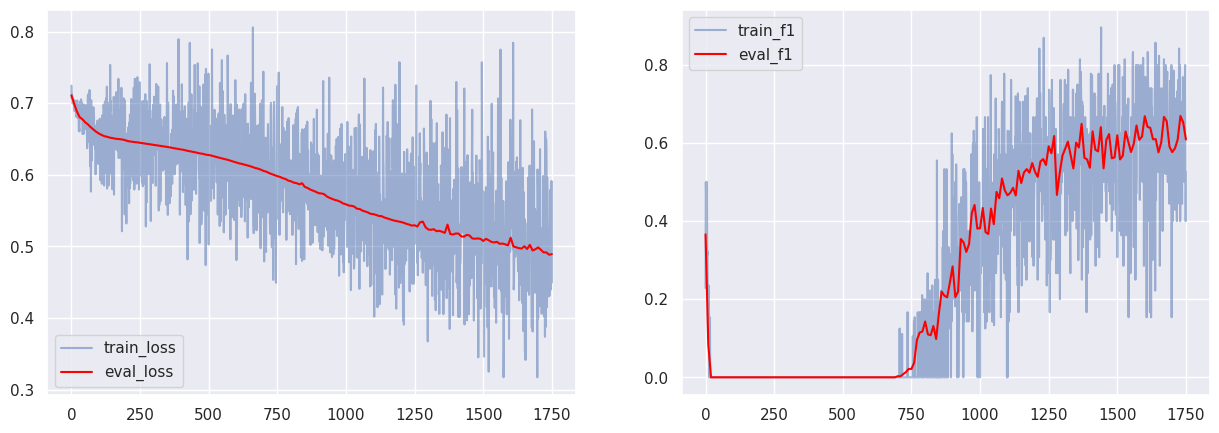

In [ ]:
model = BestTorchModel_kaiming(1, 12, 12, 3, nn.ReLU)
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01)
model = train_model(model, num_epochs=10)

In [ ]:
evaluate(model, data_loader=test_dataloader)

(0.47208324670791624, 0.6602254428341385)

Интерактив - [Initializing neural networks](https://www.deeplearning.ai/ai-notes/initialization/index.html)